3. Theoretically, increasing the number of decision trees (n_estimators), increases classifier performance and/or generalizability. How would you design and evaluate a computational experiment to test this, on the Titanic dataset? Do you find the same relationship between n_estimators and performance? If not what might be one reason?

# Import necessary packages, and read in data

In [93]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from pandas.api.types import is_string_dtype,is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [94]:
%pwd


'D:\\Information system\\Sem 1\\Info 6105\\Assignment 2'

In [95]:
'''The line below is not code, please make it into code by putting in full path'''
path = 'D:\\Information system\\Sem 1\\Info 6105\\Assignment 2'

In [96]:
#Read the data
df = pd.read_csv(f'{path}\\Titanic_full.csv')
print(df.shape)
df.head(2)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


# 2. Preprocessing data and apriori feature selection

In the broadest sense of the term, preprocessing can also include feature selection. Here, we will use our
rationale to feature select. What do the column names mean, does it make sense to what we are trying to do, and should we keep it or drop it?

There are different ways to think about it. For now, let's drop Name, Cabin and Ticket columns.

Let's see if this makes a difference.

In [97]:
'''Keep aside test data first'''

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


df_trn_val,df_tst = mydf_splitter(df,1150)

print(df_trn_val.shape,df_tst.shape)

(1150, 12) (159, 12)


In [98]:
 #Dropping the columns
df_trn_val1 = df_trn_val.drop(["Name","Cabin","Ticket"],axis = 1)
print(df_trn_val1.shape)
df_trn_val1.head(3)

(1150, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S


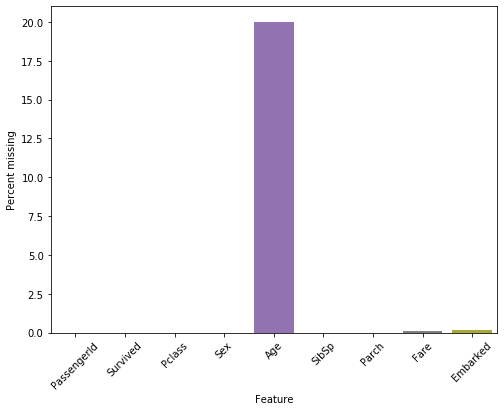

In [99]:
''' Deal with missing values. First, calculate the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = df_trn_val1.isnull().sum()/len(df_trn_val1)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [100]:
#Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [101]:
'''Define impute functions. Impute categorical NaNs with -1, 
where we add 1 to make it 0. For each 
continuous variables, we impute missing values with median values of that
column, and for every variable
where any rows were imputed, add a separate 'imputed or not' column'''

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [102]:
df_trn_val2 = str_to_cat(df_trn_val1)
print(df_trn_val2.shape)
df_trn_val2.head(3)

(1150, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S


In [103]:
df_trn_val3,my_table = mydf_preprocessor(df_trn_val2,null_table = None)
print(df_trn_val3.shape)
df_trn_val3.head(3)

(1150, 11)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_na,Fare_na
0,1,0,3,2,22.0,1,0,7.2500,3,False,False
1,2,1,1,1,38.0,1,0,71.2833,1,False,False
2,3,1,3,1,26.0,0,0,7.9250,3,False,False


In [104]:
my_table

{'Age': 28.0, 'Fare': 14.4542}

In [105]:
x = df_trn_val3.drop('Survived', axis=1)
y = df_trn_val3['Survived']

In [143]:
x_trn, x_val, y_trn, y_val = train_test_split(x, y, random_state=1)
print(x_trn.shape,x_val.shape,y_trn.shape,y_val.shape)

(862, 10) (288, 10) (862,) (288,)


How would you design and evaluate a computational experiment to test this, on the Titanic dataset?

In [136]:
from sklearn.metrics import accuracy_score

num_neighs = list()
results = list()


for i in range(1,20):
   RF_model_i = RandomForestClassifier(criterion="gini",   n_estimators=i, oob_score=True)
   RF_model_i.id = [i]
   RF_model_i.fit(x_trn, y_trn)
   y_predict_i =   RF_model_i.predict(x_val)
   accuracy_i = accuracy_score(y_val, y_predict_i)
   num_neighs.append(i)
   results.append(accuracy_i)

C:\Users\Tharoon\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Tharoon\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Tharoon\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Tharoon\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Tharoon\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. T

In [137]:
eval_df =  pd.DataFrame({"Num of neighbors": num_neighs,"Valid accuracy Score": results})
eval_df

,Num of neighbors,Valid accuracy Score
0,1,0.711806
1,2,0.694444
2,3,0.680556
3,4,0.704861
4,5,0.743056
5,6,0.725694
6,7,0.753472
7,8,0.718750
8,9,0.708333
9,10,0.718750


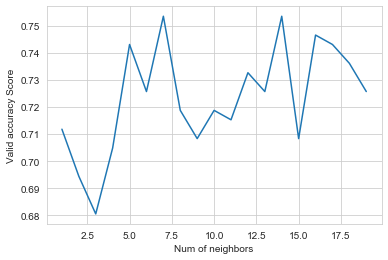

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
sns.lineplot(x = "Num of neighbors", y = "Valid accuracy Score", data=eval_df)
plt.show()

So the above graph depicts the computational experiment used to show that increasing the number of decision trees (n_estimators), does not necessarily increase classifier performance. In Most cases the statistical properties of the random forests shows that the bootstrapping procedure decreases the variance and maintain the bias. But in some cases a problem occurs which depends on the data. IN some cases if the data is not representative of the problem but if it is within the limit the tree grows but if the data being not representative and extends beyond the limit the tree gets to know the data well and the results are bad during that scenario.